In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!gsutil cp -r gs://energy_meters_dataset/dataset_v_08_19_11_19_with_annotations.zip ./

Copying gs://energy_meters_dataset/dataset_v_08_19_11_19_with_annotations.zip...
| [1 files][  1.6 GiB/  1.6 GiB]   33.1 MiB/s                                   
Operation completed over 1 objects/1.6 GiB.                                      


In [0]:
!unzip -qq /content/dataset_v_08_19_11_19_with_annotations.zip

In [0]:
DATASET_DIR='dataset_v_08_19_11_19/'
IMAGE_DIR=DATASET_DIR+'energy_meter/'
ANN_DIR=DATASET_DIR+'annotations/'
MAP_DIR=DATASET_DIR+'maps/'

In [0]:
#!gcloud init

In [0]:
#!gsutil cp -r gs://energy_meters_dataset/via_region_data.csv /content/data.csv

In [0]:
#!mv /content/data.csv {ANN_DIR}

In [0]:
import os
import pandas as pd
import json

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil

In [0]:
os.listdir(ANN_DIR)

3320

In [0]:
!rm -rf {MAP_DIR}
!mkdir {MAP_DIR}

In [0]:
anns=os.listdir(ANN_DIR)

In [0]:
def format_name(fname):
  dot_split=fname.split('.')
  s=dot_split[len(dot_split)-1]
  no_digits = []
  # Iterate through the string, adding non-numbers to the no_digits list
  for i in s:
      if not i.isdigit():
          no_digits.append(i)

  # Now join all elements of the list with '', 
  # which puts all of the characters together.
  result = ''.join(no_digits)
  dot_split=dot_split[:len(dot_split)-1]
  result='.'.join([*dot_split,result])
  return result

In [0]:
def parse_anot_rect(fname,img_path):
  f= open(f'{fname}',"r")
  parsed_json = (json.loads(f.read()))
  data_keys=parsed_json['_via_img_metadata'].keys()
  rect_regions=[]
  for k in data_keys:
    #print(k)
    cur_data=parsed_json['_via_img_metadata'][k]['regions']
    out_data=[]
    for data in cur_data:
      d=[]
      #print(data['shape_attributes'].keys())
      #print(data['region_attributes']['name'])
      if(data['shape_attributes']['name']=='rect'):
        #try:
          #if(data['region_attributes'])
        #rect_region_keys=data['shape_attributes'].keys()
        #print(data['shape_attributes']['all_points_x'].keys())
        print(data['region_attributes'].keys())
        if(('value' in data['region_attributes'].keys()) and ('name' in data['region_attributes'].keys())):
            for shape_key in data['shape_attributes'].keys():
              d.append(data['shape_attributes'][shape_key])
            #print(len(data['region_attributes']['name'].keys()))
            if(type(data['region_attributes']['name']) is not type('')):
              if(len(data['region_attributes']['name'].keys())==1 and 'number' in data['region_attributes']['name'].keys()):
                d.append('number')
              elif(len(data['region_attributes']['name'].keys())==1 and 'serial_number' in data['region_attributes']['name'].keys()):
                d.append('serial_number')
              d.append(data['region_attributes']['value'])
              
            else:
              if('number'==data['region_attributes']['name']):
                d.append('number')
              elif('serial_n'==data['region_attributes']['name']):
                d.append('serial_number')
              d.append(data['region_attributes']['value'])
          #print(d)
        #except:
          #pass
      if(len(d)!=0):
        out_data.append(d)
    if(len(out_data)==2):
      rect_regions.append([img_path+format_name(k),*out_data[0],*out_data[1]])
    #if(len(cur_data)>0):
      #print(cur_data[0]['shape_attributes']['name'])
  f.close()
  return rect_regions

In [0]:
def parse_anot_poly(fname,img_path):
  f= open(f'{fname}',"r")
  parsed_json = (json.loads(f.read()))
  data_keys=parsed_json['_via_img_metadata'].keys()
  #print(data_keys)
  poly_regions=[]
  for k in data_keys:
    #print(k)
    cur_data=parsed_json['_via_img_metadata'][k]['regions']
    out_data=[]
    for data in cur_data:
      d=[]
      #print(data['shape_attributes'].keys())
      #print(data['shape_attributes']['name'])
      #print(data['region_attributes'])
      if(data['shape_attributes']['name']=='polygon'):
        #try:
          #if(data['region_attributes'])
        #rect_region_keys=data['shape_attributes'].keys()
        #print(data['shape_attributes']['all_points_x'].keys())
          if(('value' in data['region_attributes'].keys()) and ('name' in data['region_attributes'].keys())):
            for shape_key in data['shape_attributes'].keys():
              d.append(data['shape_attributes'][shape_key])
            #print(len(data['region_attributes']['name'].keys()))
            #print(data['region_attributes']['name'])
            if(type(data['region_attributes']['name']) is not type('')):
              if(len(data['region_attributes']['name'].keys())==1 and 'number' in data['region_attributes']['name'].keys()):
                d.append('number')
              elif(len(data['region_attributes']['name'].keys())==1 and 'serial_number' in data['region_attributes']['name'].keys()):
                d.append('serial_number')
              d.append(data['region_attributes']['value'])
            else:
              if('number'==data['region_attributes']['name']):
                d.append('number')
              elif('serial_n'==data['region_attributes']['name']):
                d.append('serial_number')
              d.append(data['region_attributes']['value'])
          
          #print(d)
        #except:
        #  pass
      if(len(d)!=0):
        out_data.append(d)
    if(len(out_data)==2):
      poly_regions.append([img_path+format_name(k),*out_data[0],*out_data[1]])
    #if(len(cur_data)>0):
      #print(cur_data[0]['shape_attributes']['name'])
  f.close()
  return poly_regions

In [0]:
def parse_anot(fname,img_path,skip_step=False):
  f= open(f'{fname}',"r")
  if(skip_step):
    parsed_json = (json.loads(f.read()))
  else:
    parsed_json = (json.loads(f.read()))['_via_img_metadata']
  data_keys=parsed_json.keys()
  regions=[]
  for k in data_keys:
    #print(k)
    cur_data=parsed_json[k]['regions']
    #out_data=[]
    for data in cur_data:
      d={
          'fname':None,
          'name':None,
         'x':None,
         'y':None,
         'width':None,
         'height':None,
         'all_x':None,
         'all_y':None,
         'class':None,
         'value':None,
         #'':None,
         #'':None,

      }
      d['fname']=img_path+format_name(k)
      print(data['region_attributes'])
      if('name' in data['shape_attributes'].keys()):
        d['name']=data['shape_attributes']['name']
      if('x' in data['shape_attributes'].keys()):
        d['x']=data['shape_attributes']['x']
      if('y' in data['shape_attributes'].keys()):
        d['y']=data['shape_attributes']['y']
      if('width' in data['shape_attributes'].keys()):
        d['width']=data['shape_attributes']['width']
      if('height' in data['shape_attributes'].keys()):
        d['height']=data['shape_attributes']['height']
      if('all_points_x' in data['shape_attributes'].keys()):
        d['all_x']=data['shape_attributes']['all_points_x']
      if('all_points_y' in data['shape_attributes'].keys()):
        d['all_y']=data['shape_attributes']['all_points_y']
      if(('name' in data['region_attributes'].keys()) and ('value' in data['region_attributes'].keys())):
        if(type(data['region_attributes']['name']) is type('')):
          if('serial' in data['region_attributes']['name']):
            d['class']='serial_number'
          else:
            d['class']='number'
        else:
          if('serial_number' in data['region_attributes']['name'].keys()):
            d['class']='serial_number'
          elif('number' in data['region_attributes']['name'].keys()):
            d['class']='number'
          else:
            d['class']=data['region_attributes']['name']
        d['value']=data['region_attributes']['value']
      regions.append(d)
  f.close()
  return regions

In [0]:
all_reg=[]

an='/content/dataset_v_08_19_11_19/annotations/sasha_250_530_via_project_22Nov2019_16h31m.json'
reg=parse_anot(an,IMAGE_DIR)
all_reg+=reg

an='/content/dataset_v_08_19_11_19/annotations/zack_0-253_via_project_20Nov2019_12h9m.json'
reg=parse_anot(an,IMAGE_DIR)
all_reg+=reg

an='/content/dataset_v_08_19_11_19/shift_lab_dataset_173photo_plus_labels/2_5386837116099494864.json'
reg=parse_anot(an,'/content/dataset_v_08_19_11_19/shift_lab_dataset_173photo_plus_labels/good_q/')
all_reg+=reg

{'name': {'number': True}, 'value': '000003'}
{'value': '25002510', 'name': {'serial_number': True}}
{'value': '000002', 'name': {'number': True}}
{'value': '103193711', 'name': {'serial_number': True}}
{'value': '000676', 'name': {'number': True}}
{'value': '3N031261', 'name': {'serial_number': True}}
{'value': '1000003', 'name': {'number': True}}
{'value': '1453189', 'name': {'serial_number': True}}
{'value': '053918', 'name': {'number': True}}
{'value': '007791088045742', 'name': {'serial_number': True}}
{'value': '000002', 'name': {'number': True}}
{'value': '', 'name': {'serial_number': True}}
{'value': '0017712', 'name': {'number': True}}
{'value': '009082010001104', 'name': {'serial_number': True}}
{'value': '002914', 'name': {'number': True}}
{'value': '011067091180652', 'name': {'serial_number': True}}
{'value': '0000020', 'name': {'number': True}}
{'value': '007519132001813', 'name': {'serial_number': True}}
{'value': '084585', 'name': {'number': True}}
{'value': '091522568',

In [0]:
#data=pd.read_csv('/content/dataset_v_08_19_11_19/annotations/via_region_data.csv')

In [0]:
reg_df=pd.DataFrame(all_reg)

In [0]:
len(reg_df)

1312

In [0]:
filt_df=pd.concat([reg_df[reg_df['class']== 'number'] , reg_df[reg_df['class']== 'serial_number']]).reset_index()

In [0]:
filt_df[filt_df['class']=='serial_number']['fname'].nunique()

443

In [0]:
filt_df['fname']

0      dataset_v_08_19_11_19/energy_meter/good (174).jpg
1      dataset_v_08_19_11_19/energy_meter/good (175).jpg
2      dataset_v_08_19_11_19/energy_meter/good (176).jpg
3      dataset_v_08_19_11_19/energy_meter/good (177).jpg
4      dataset_v_08_19_11_19/energy_meter/good (178).jpg
                             ...                        
886    /content/dataset_v_08_19_11_19/shift_lab_datas...
887    /content/dataset_v_08_19_11_19/shift_lab_datas...
888    /content/dataset_v_08_19_11_19/shift_lab_datas...
889    /content/dataset_v_08_19_11_19/shift_lab_datas...
890    /content/dataset_v_08_19_11_19/shift_lab_datas...
Name: fname, Length: 891, dtype: object

In [0]:
def convert_points(ax,ay):
  points=np.zeros((len(ax),2))
  for i in range(len(ax)):
    points[i,0]=ax[i]
    points[i,1]=ay[i]
  #points=np.array(points)
  #print(ax,ay,points)
  return points
def draw_rect(data):
  fname=data['fname']
  im=cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
  mask=np.zeros(im.shape)
  x=int(data['x'])
  y=int(data['y'])
  width=int(data['width'])
  height=int(data['height'])
  cv2.rectangle(mask,(x,y),(x+width,y+height),255,-1)
  return mask
def draw_poly(data):
  fname=data['fname']
  #print(fname)
  im=cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
  #print(im.shape)
  mask=np.zeros(im.shape)
  x=data['all_x']
  y=data['all_y']
  p=convert_points(x,y)
  #print(p[0])
  cv2.fillPoly(mask,np.int32([p]),255)
  #mask.shape
  return mask
def draw_reg(data):
  if(data['name']=='rect'):
    return draw_rect(data)
  elif(data['name']=='polygonal' or data['name']=='polygon'):
    return draw_poly(data)

In [0]:
def extract_rect(data):
  fname=data['fname']
  im=cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
  x=int(data['x'])
  y=int(data['y'])
  width=int(data['width'])
  height=int(data['height'])
  res=im[y:y+height,x:x+width]
  return res
def extract_poly(data):
  fname=data['fname']
  #print(fname)
  im=cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
  #print(im.shape)
  mask=np.zeros(im.shape)
  x=data['all_x']
  y=data['all_y']
  p=convert_points(x,y)
  cv2.fillPoly(mask,np.int32([p]),255)

  return mask

In [0]:
files_df=[]
save_df=[]
n_value_df=[]
s_value_df=[]
fnames=filt_df['fname'].unique()
for i in tqdm(range(len(fnames))):
  f=fnames[i]
  df=filt_df[filt_df['fname']==f]
  if(len(filt_df[filt_df['fname']==f])==2):
    if(df['class'].nunique()==2):
      number_df=df[df['class']=='number'].iloc[0]
      ser_number_df=df[df['class']=='serial_number'].iloc[0]
      files_df.append(number_df['fname'])
      #try:
      mask1=draw_reg(number_df)
      mask2=draw_reg(ser_number_df)
      res_mask=np.zeros((*mask1.shape,3),np.uint8)
      #print(np.max(mask1),np.max(mask2))
      res_mask[:,:,0]=mask1
      res_mask[:,:,1]=mask2
      cv2.imwrite(MAP_DIR+f'{i}.png',res_mask)
      n_value_df.append(number_df['value'])
      s_value_df.append(ser_number_df['value'])
      save_df.append(MAP_DIR+f'{i}.png')
      #except:
      #  print(number_df['fname'])

    #print(filt_df[filt_df['fname']==f])



100%|██████████| 449/449 [00:21<00:00, 20.42it/s]


In [0]:
import os
import numpy as np
from keras.utils import np_utils
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.models import Sequential,Model
from keras.layers import Dense, Reshape, Input,Dropout
from keras.layers import Dropout
from keras.layers import Flatten,Activation,concatenate,BatchNormalization
from keras.layers.convolutional import Conv2D,MaxPooling2D,Conv2DTranspose
from sklearn.model_selection import train_test_split
import keras
from PIL import Image
import tensorflow as tf
from keras import backend as K
import cv2


import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#from scipy.ndimage import imread
class DataGeneratorFull(Sequence):
    'Generates data for Keras'
    def __init__(self, files, target_df=None, mode='fit',
                 base_path = '../input/recursion-cellular-image-classification/train',
                 batch_size=32, dim=(640, 512), n_channels=1,size=9,
                 rotation_range=0, fill_mode='nearest',
                 vertical_flip=False, horizontal_flip=False, rescale=1/255.,
                 n_classes=5, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.files=files
        self.mode = mode
        self.size=size
        self.base_path = base_path
        self.rotation_range=rotation_range
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.rescale = rescale
        self.vertical_flip = vertical_flip
        self.horizontal_flip = horizontal_flip
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int((len(self.files) / self.batch_size))

    def __getitem__(self, index):

        batch_files = self.files[index*self.batch_size:(index+1)*self.batch_size]
        
        X = self.__generate_X(batch_files)
        
        if self.mode == 'fit':
            y = self.__generate_y(batch_files)
            return X, y
        
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('The parameter mode should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, batch_files):
        buf=np.empty((self.batch_size, 512,512,3))
        for i in range(len(batch_files)):
          if self.mode == 'fit':
            b=cv2.imread(batch_files.iloc[i]['fname'])
          else:
            b=cv2.imread(batch_files[i])
          b=cv2.resize(b,(512,512))
          b=b*self.rescale
          buf[i,]=b
          

        return buf
    
    def __generate_y(self, batch_files):
        buf=np.empty((self.batch_size, 512,512,2))
        for i in range(len(batch_files)):
            b=cv2.imread(batch_files.iloc[i]['sname'], cv2.IMREAD_UNCHANGED)
            b=cv2.resize(b,(512,512))
            b=b*self.rescale
            buf[i,:,:,0]=b[:,:,0]
            buf[i,:,:,1]=b[:,:,1]
        return buf


In [0]:
#from scipy.ndimage import imread
class DataGeneratorFull(Sequence):
    'Generates data for Keras'
    def __init__(self, files, target_df=None, mode='fit',
                 base_path = '../input/recursion-cellular-image-classification/train',
                 batch_size=32, dim=(640, 512), n_channels=1,size=9,
                 rotation_range=0, fill_mode='nearest',
                 vertical_flip=False, horizontal_flip=False, rescale=1/255.,
                 n_classes=5, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.files=files
        self.mode = mode
        self.size=size
        self.base_path = base_path
        self.rotation_range=rotation_range
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.rescale = rescale
        self.vertical_flip = vertical_flip
        self.horizontal_flip = horizontal_flip
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int((len(self.files) / self.batch_size))

    def __getitem__(self, index):

        batch_files = self.files[index*self.batch_size:(index+1)*self.batch_size]
        
        X = self.__generate_X(batch_files)
        
        if self.mode == 'fit':
            y = self.__generate_y(batch_files)
            return X, y
        
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('The parameter mode should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, batch_files):
        buf=np.empty((self.batch_size, 512,512,3))
        for i in range(len(batch_files)):
          if self.mode == 'fit':
            b=cv2.imread(batch_files.iloc[i]['fname'])
          else:
            b=cv2.imread(batch_files[i])
          b=cv2.resize(b,(512,512))
          b=b*self.rescale
          buf[i,]=b
          

        return buf
    
    def __generate_y(self, batch_files):
        buf=np.empty((self.batch_size, 512,512,3))

        for i in range(len(batch_files)):

          if self.mode == 'fit':
            b=cv2.imread(batch_files.iloc[i]['fname'])
            bm=cv2.imread(batch_files.iloc[i]['sname'])
          else:
            b=cv2.imread(batch_files[i])
          cbm,_=cv2.findContours(bm[:,:,0], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

          rect =cv2.boundingRect(cbm[0])
          b=b[int(rect[1]):int(rect[1])+int(rect[3]),int(rect[0]):int(rect[0])+int(rect[2]),:]
          b=cv2.resize(b,(512,512))
          buf[i,]=b
          
        buf=buf*self.rescale
        return buf

In [0]:
all_files1=pd.DataFrame(files_df,columns=['fname'])
all_files2=pd.DataFrame(save_df,columns=['sname'])
all_files3=pd.DataFrame(n_value_df,columns=['value_n'])
all_files4=pd.DataFrame(s_value_df,columns=['value_s'])
all_files=pd.concat([all_files1,all_files2,all_files3,all_files4],axis=1)

In [0]:
all_files

,fname,sname,value_n,value_s
0,dataset_v_08_19_11_19/energy_meter/good (174).jpg,dataset_v_08_19_11_19/maps/0.png,000003,25002510
1,dataset_v_08_19_11_19/energy_meter/good (175).jpg,dataset_v_08_19_11_19/maps/1.png,000002,103193711
2,dataset_v_08_19_11_19/energy_meter/good (176).jpg,dataset_v_08_19_11_19/maps/2.png,000676,3N031261
3,dataset_v_08_19_11_19/energy_meter/good (177).jpg,dataset_v_08_19_11_19/maps/3.png,1000003,1453189
4,dataset_v_08_19_11_19/energy_meter/good (178).jpg,dataset_v_08_19_11_19/maps/4.png,053918,007791088045742
...,...,...,...,...
431,/content/dataset_v_08_19_11_19/shift_lab_datas...,dataset_v_08_19_11_19/maps/437.png,4711,00452443
432,/content/dataset_v_08_19_11_19/shift_lab_datas...,dataset_v_08_19_11_19/maps/438.png,577,08443783
433,/content/dataset_v_08_19_11_19/shift_lab_datas...,dataset_v_08_19_11_19/maps/439.png,4711,00452443
434,/content/dataset_v_08_19_11_19/shift_lab_datas...,dataset_v_08_19_11_19/maps/440.png,30,07541002


In [0]:
train_files, val_files = train_test_split(
    all_files, test_size=0.15, random_state=2019
)

In [0]:
gen=DataGeneratorFull(train_files,batch_size=4)
val=DataGeneratorFull(val_files,batch_size=4)

In [0]:
%%time
im=gen.__getitem__(0)

CPU times: user 122 ms, sys: 18.3 ms, total: 140 ms
Wall time: 146 ms


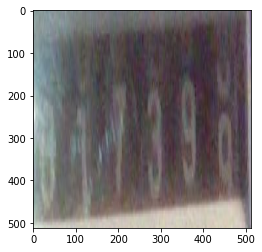

In [0]:
plt.imshow(im[1][0])

In [0]:
#!git clone https://github.com/bonlime/keras-deeplab-v3-plus

Cloning into 'keras-deeplab-v3-plus'...
remote: Enumerating objects: 279, done.
remote: Total 279 (delta 0), reused 0 (delta 0), pack-reused 279
Receiving objects: 100% (279/279), 5.10 MiB | 9.05 MiB/s, done.
Resolving deltas: 100% (140/140), done.


In [0]:
#!mv keras-deeplab-v3-plus deeplab

In [0]:
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
def unet(input_size = (32,32,1),descr=8,activation='sigmoid'):
    #descr=2
    inputs = Input(input_size)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = keras.layers.Dropout(0.5)(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = keras.layers.Dropout(0.5)(conv5)

    up6 = keras.layers.Conv2D(int(512/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = keras.layers.Conv2D(int(256/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = keras.layers.Conv2D(int(128/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = keras.layers.Conv2D(int(64/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = keras.layers.Conv2D(3, 3, padding = 'same',activation = activation)(conv9)

    model = Model(input = inputs, output = conv10)
    
    model.summary()

    return model

In [0]:
!git clone https://github.com/sbillburg/CRNN-with-STN

Cloning into 'CRNN-with-STN'...
remote: Enumerating objects: 175, done.
remote: Total 175 (delta 0), reused 0 (delta 0), pack-reused 175
Receiving objects: 100% (175/175), 94.35 KiB | 4.10 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [0]:
!mv CRNN-with-STN CRNN

In [0]:
from CRNN.STN.spatial_transformer import SpatialTransformer
def loc_net(input_shape):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    w = np.zeros((64, 6), dtype='float32')
    weights = [w, b.flatten()]

    loc_input = Input(input_shape)

    loc_conv_1 = Conv2D(16, (5, 5), padding='same', activation='relu')(loc_input)
    loc_conv_2 = Conv2D(32, (5, 5), padding='same', activation='relu')(loc_conv_1)
    loc_fla = Flatten()(loc_conv_2)
    loc_fc_1 = Dense(64, activation='relu')(loc_fla)
    loc_fc_2 = Dense(6, weights=weights)(loc_fc_1)

    output = Model(inputs=loc_input, outputs=loc_fc_2)

    return output

def build_stn_model(input_shape=(512,512,3)):
  inp=keras.layers.Input(input_shape)
  stn_input_shape = inp.get_shape()
  loc_input_shape = (stn_input_shape[1].value, stn_input_shape[2].value, stn_input_shape[3].value)
  stn = SpatialTransformer(localization_net=loc_net(loc_input_shape),
                          output_size=(loc_input_shape[0], loc_input_shape[1]))(inp)
  return keras.models.Model(inputs=[inp],outputs=[stn])


In [0]:
model=build_stn_model()

In [0]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
spatial_transformer_4 (Spati (None, 512, 512, 3)       536885414 
Total params: 536,885,414
Trainable params: 536,885,414
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras import backend as bknd
from keras.callbacks import *
from keras.layers import *
from keras.models import *
from keras.optimizers import SGD
from keras.utils import *

from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

from CRNN.STN.spatial_transformer import SpatialTransformer



width=512
height=512
# functions
class Evaluate(Callback):

    def on_epoch_end(self, epoch, logs=None):
        acc = evaluate(base_model)
        print('')
        print('acc:'+str(acc)+"%")

evaluator = Evaluate()


def evaluate(input_model):
    correct_prediction = 0
    generator = img_gen_val()

    x_test, y_test = next(generator)
    # print(" ")
    y_pred = input_model.predict(x_test) 
    shape = y_pred[:, 2:, :].shape 
    ctc_decode = bknd.ctc_decode(y_pred[:, 2:, :], input_length=np.ones(shape[0])*shape[1])[0][0]
    out = bknd.get_value(ctc_decode)[:, :label_len]

    for m in range(1000):
        result_str = ''.join([characters[k] for k in out[m]])
        result_str = result_str.replace('-', '')
        if result_str == y_test[m]:
            correct_prediction += 1
            # print(m)
        else:
            print(result_str, y_test[m])

    return correct_prediction*1.0/10


def ctc_lambda_func(args):
    iy_pred, ilabels, iinput_length, ilabel_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    iy_pred = iy_pred[:, 2:, :]  # no such influence
    return bknd.ctc_batch_cost(ilabels, iy_pred, iinput_length, ilabel_length)


# initial bias_initializer
def loc_net(input_shape):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    w = np.zeros((64, 6), dtype='float32')
    weights = [w, b.flatten()]

    loc_input = Input(input_shape)

    loc_conv_1 = Conv2D(16, (5, 5), padding='same', activation='relu')(loc_input)
    loc_conv_2 = Conv2D(32, (5, 5), padding='same', activation='relu')(loc_conv_1)
    loc_fla = Flatten()(loc_conv_2)
    loc_fc_1 = Dense(64, activation='relu')(loc_fla)
    loc_fc_2 = Dense(6, weights=weights)(loc_fc_1)

    output = Model(inputs=loc_input, outputs=loc_fc_2)

    return output


# build model
inputShape = Input((width, height, 3))  # base on Tensorflow backend

batchnorm_7 = BatchNormalization()(conv_7)

bn_shape = batchnorm_7.get_shape()  # (?, {dimension}50, {dimension}12, {dimension}256)

'''----------------------STN-------------------------'''
# you can run the model without this STN part by commenting out the STN lines then connecting batchnorm_7 to x_reshape,
# which may bring you a higher accuracy
stn_input_shape = batchnorm_7.get_shape()
loc_input_shape = (stn_input_shape[1].value, stn_input_shape[2].value, stn_input_shape[3].value)
stn = SpatialTransformer(localization_net=loc_net(loc_input_shape),
                         output_size=(loc_input_shape[0], loc_input_shape[1]))(batchnorm_7)
'''----------------------STN-------------------------'''

print(bn_shape)  # (?, 50, 7, 512)

# reshape to (batch_size, width, height*dim)
# x_reshape = Reshape(target_shape=(int(bn_shape[1]), int(bn_shape[2] * bn_shape[3])))(stn_7)
x_reshape = Reshape(target_shape=(int(bn_shape[1]), int(bn_shape[2] * bn_shape[3])))(stn)

fc_1 = Dense(128, activation='relu')(x_reshape)  # (?, 50, 128)

print(x_reshape.get_shape())  # (?, 50, 3584)
print(fc_1.get_shape())  # (?, 50, 128)

rnn_1 = LSTM(128, kernel_initializer="he_normal", return_sequences=True)(fc_1)
rnn_1b = LSTM(128, kernel_initializer="he_normal", go_backwards=True, return_sequences=True)(fc_1)
rnn1_merged = add([rnn_1, rnn_1b])

rnn_2 = LSTM(128, kernel_initializer="he_normal", return_sequences=True)(rnn1_merged)
rnn_2b = LSTM(128, kernel_initializer="he_normal", go_backwards=True, return_sequences=True)(rnn1_merged)
rnn2_merged = concatenate([rnn_2, rnn_2b])

drop_1 = Dropout(0.25)(rnn2_merged)

fc_2 = Dense(11, kernel_initializer='he_normal', activation='softmax')(drop_1)

# model setting
base_model = Model(inputs=inputShape, outputs=fc_2)  # the model for prediecting

labels = Input(name='the_labels', shape=[8], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([fc_2, labels, input_length, label_length])

model = Model(inputs=[inputShape, labels, input_length, label_length], outputs=[loss_out])  # the model for trainning


(?, 128, 128, 512)
(?, 128, 65536)
(?, 128, 128)


KeyboardInterrupt: ignored

In [0]:
#from deeplab.model import Deeplabv3
#model = Deeplabv3(input_shape=(512, 512, 3), classes=3,activation='relu') 
model=unet(input_size=(512,512,3),descr=8,activation='relu')

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 512, 512, 8)  224         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 512, 512, 8)  584         conv2d_97[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 256, 256, 8)  0           conv2d_98[0][0]                  
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [0]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 512, 512, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 128 73856       conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 512, 512, 256 295168      conv2d_20[0][0]                  
____________________________________________________________________________________________

In [0]:
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [0]:
import tensorflow as tf

import math
from keras import backend as K


def ssim_loss(y_true, y_pred):
  return 1-tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

In [0]:
model.compile('adam',loss=ssim_loss,metrics=['acc','mse'])

In [0]:
gen=DataGeneratorFull(train_files,batch_size=4)
val=DataGeneratorFull(val_files,batch_size=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


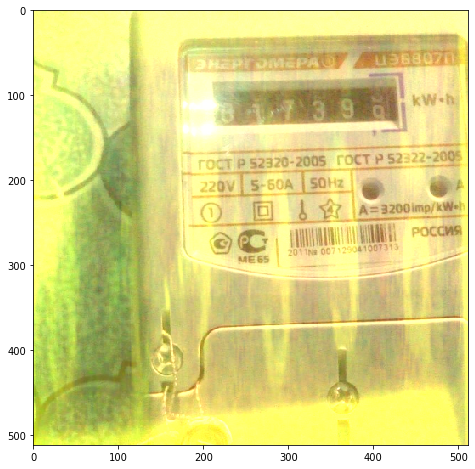

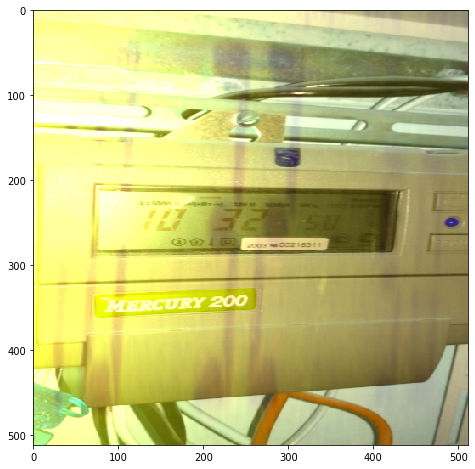

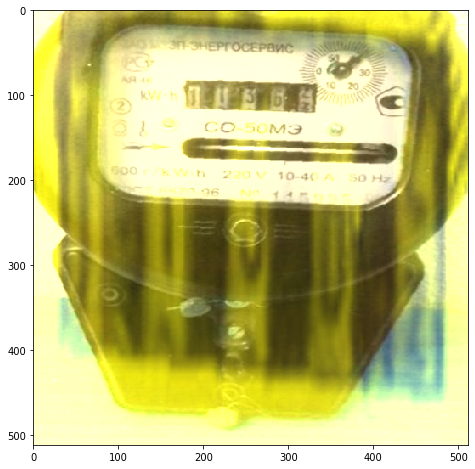

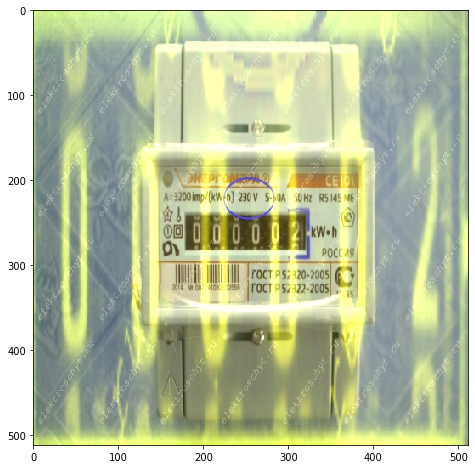

In [0]:
gen_data=gen.__getitem__(0)
for i in range(len(gen_data[0])):
  fig,axs=plt.subplots(figsize=(8,8))
  gen_data[0][i,:,:,0]+=gen_data[1][i,:,:,0]
  gen_data[0][i,:,:,1]+=gen_data[1][i,:,:,1]
  axs.imshow(gen_data[0][i])

In [0]:
check=keras.callbacks.ModelCheckpoint('res_weights.h5', monitor='val_loss',save_best_only=True)

In [0]:
history = model.fit_generator(
    gen,
    validation_data=val,
    use_multiprocessing=False,
    workers=4,
    epochs=20,
    verbose=1,
    shuffle=True,
    callbacks=[check]
)



Epoch 1/20


ResourceExhaustedError: ignored

In [0]:
model.load_weights('res_weights.h5')

In [0]:
#model.compile('adam',loss='binary_crossentropy',metrics=['acc'])

In [0]:
#model.save('unet_seg.h5')

In [0]:
test_files=val_files['fname'].values[0:4]
pred_gen=DataGeneratorFull(test_files,batch_size=len(test_files),mode='predict')


In [0]:
%%time
res=model.predict_generator(pred_gen)

CPU times: user 2.54 s, sys: 42.1 ms, total: 2.58 s
Wall time: 2.12 s


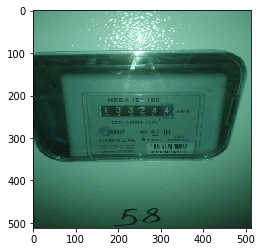

In [0]:
plt.imshow(pred_gen[0][3])

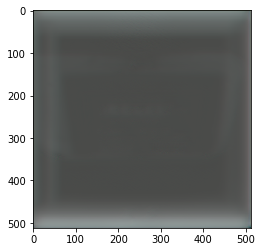

In [0]:

plt.imshow(res[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


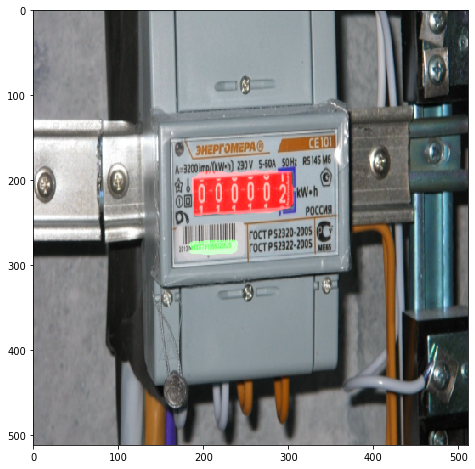

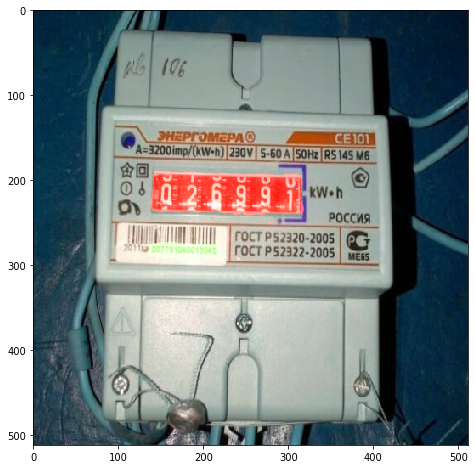

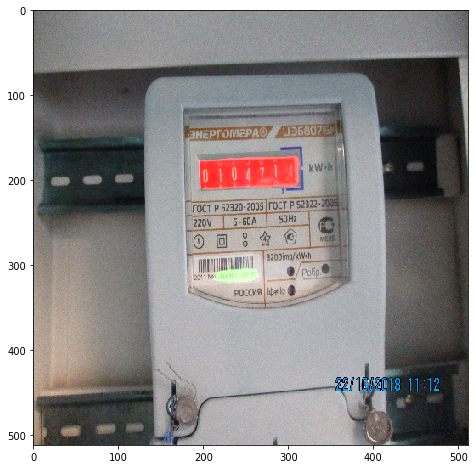

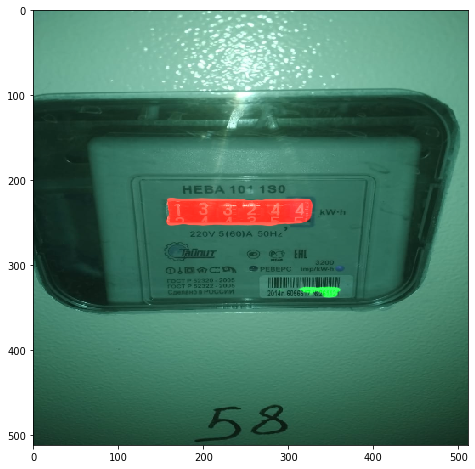

In [0]:
imgs=pred_gen.__getitem__(0)
val_imgs=val.__getitem__(0)
for i in range(len(imgs)):
  mask=res[i]
  imgs[i,:,:,0]+=mask[:,:,0]
  imgs[i,:,:,1]+=mask[:,:,1]
  fig,axs=plt.subplots(1,figsize=(8,8))
  axs.imshow(imgs[i,:,:])

In [0]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
model.save('deeplav_v3.h5')

In [0]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils import CustomObjectScope
def relu6(x):
  return K.relu(x, max_value=6)
with CustomObjectScope({'relu6': relu6}):
   # model = load_model('weights.hdf5')
# Convert the mogff
    converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file('deeplav_v3.h5')
    tflite_model = converter.convert()
    # Create the gfftflite model file
    tflite_model_name = "unet_seg.tflite"
    open(tflite_model_name, "wb").write(tflite_model)

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 46 variables.
INFO:tensorflow:Converted 46 variables to const ops.
